In [1]:
import scipy as sp
import numpy as np
from numpy import pi, sqrt
import matplotlib.pyplot as plt
import qutip as qt
from qutip import hinton, identity, to_super, sigmaz, tensor, tensor_contract, sigmax, projection, jmat, basis, propagator, coefficient

In [2]:
Sz = tensor(jmat(1/2,'z'), identity([2]))
Sx = tensor(jmat(1/2,'x'),identity([2]))
Sy = tensor(jmat(1/2,'y'),identity([2]))

Iz = tensor(identity(2), jmat(1/2,'z'))
Ix = tensor(identity(2), jmat(1/2,'x'))
Iy = tensor(identity(2), jmat(1/2,'y'))

In [185]:
sqrt2 = np.sqrt(2)
isqrt2 = 1/np.sqrt(2)

GHz=1e3
MHz=1
kHz=1e-3

ms=1e3
us=1
ns=1e-3

T = 1e4
G = 1

B = 364

gamma_e = -28024 * MHz / T
gamma_p = 42.577 * MHz / T
gamma_N = -4.316 * MHz / T

omegaNV =  2.87 * GHz + gamma_e * B
omegaX = gamma_e * B
omegaN15 = gamma_N * B
omegaP = gamma_p * B

D = 60 * kHz
Omega = 1 * MHz

T1e = 1*ms
T2e = 4*us
T1n = 10*ms
T2n = 500*us

T1e_rho = 100*us # this is emergent, no need to add directly

t_swap_nvx = 7.95*us

deg = np.pi/180

In [234]:
gamma_p

0.0042577

In [186]:
e0 = basis(2,0)
e1 = basis(2,1)
n0 = basis(2,0)
n1 = basis(2,1)

ket00 = tensor(e0,n0)
ket01 = tensor(e0,n1)
ket10 = tensor(e1,n0)
ket11 = tensor(e1,n1)

rho00 = tensor(projection(2,0,0), projection(2,0,0))
rho01 = tensor(projection(2,0,0), projection(2,1,1))
rho10 = tensor(projection(2,1,1), projection(2,0,0))
rho11 = tensor(projection(2,1,1), projection(2,1,1))

In [207]:
A_para = 20.1192 * MHz
A_perp = 17.1582 * MHz
A = [A_perp, 0, A_para]

In [208]:
H = 2*pi*(omegaX * Sz + omegaP * Iz + A[2] * (Sz * Iz) + A[0] * (Sz * Ix) + A[1] * (Sz * Iy))

H/(2*pi)

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[-504.2320986    4.28955      0.           0.       ]
 [   4.28955   -515.8415014    0.           0.       ]
 [   0.           0.         505.7819014   -4.28955  ]
 [   0.           0.          -4.28955    514.2916986]]

In [209]:
energies = H.eigenenergies()/(2*pi)
energies

array([-517.25447259, -502.81912741,  503.99491277,  516.07868723])

In [210]:
omega_right = energies[3]-energies[0]
omega_left = energies[2]-energies[1]
omega_top = energies[3]-energies[2]
omega_bot = energies[1]-energies[0]

In [211]:
H_right = 2*pi*( (omegaX + omega_right) * Sz + Omega*Sx + A[2] * (Sz * Iz) + A[0] * (Sz * Ix) + A[1] * (Sz * Iy)  + omegaP * Iz)

H_right

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 78.12815025  26.95203753   3.14159265   0.        ]
 [ 26.95203753   5.18412116   0.           3.14159265]
 [  3.14159265   0.         -68.39045207 -26.95203753]
 [  0.           3.14159265 -26.95203753 -14.92181934]]

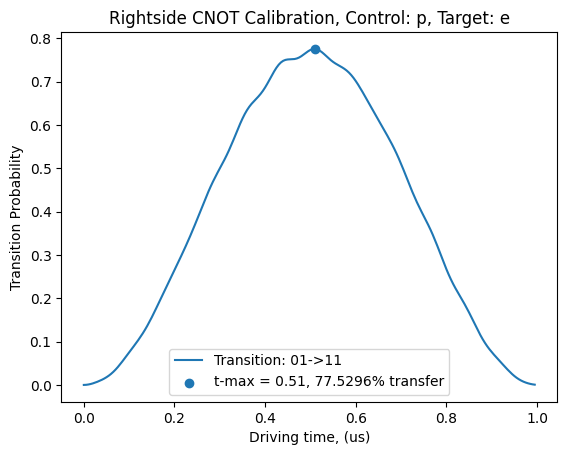

In [212]:
times = np.arange(0,1,.005)

resE = qt.mesolve(H_right,rho01,times)
signal = [qt.expect(rho11, state) for state in resE.states]
t_cnot_e = times[np.argmax(signal)]

plt.plot(times,signal,label="Transition: 01->11")
#plt.plot(times,signal_other,label="Leakage")
plt.scatter(t_cnot_e, np.max(signal),label=f"t-max = {t_cnot_e}, {round(np.max(signal)*100,4)}% transfer")
plt.xlabel("Driving time, (us)")
plt.ylabel("Transition Probability")
plt.title("Rightside CNOT Calibration, Control: p, Target: e")
plt.legend()
plt.show()

In [213]:
cnot_e = propagator(H_right, t_cnot_e)

In [214]:
cost = coefficient(lambda t: np.cos(2*pi*omega_top*t))
sint = coefficient(lambda t: np.sin(2*pi*omega_top*t))

In [215]:
# this is a time dependent hamiltonian with slow terms that might matter

H_top =  2*pi*( (omegaP+omega_top) * Iz + A[2] * (Sz * Iz) + A[0]*Sz*Ix + 40 * kHz*Ix)

H_top

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 74.43431162  27.07770124   0.           0.        ]
 [ 27.07770124 -74.43431162   0.           0.        ]
 [  0.           0.          11.2279807  -26.82637383]
 [  0.           0.         -26.82637383 -11.2279807 ]]

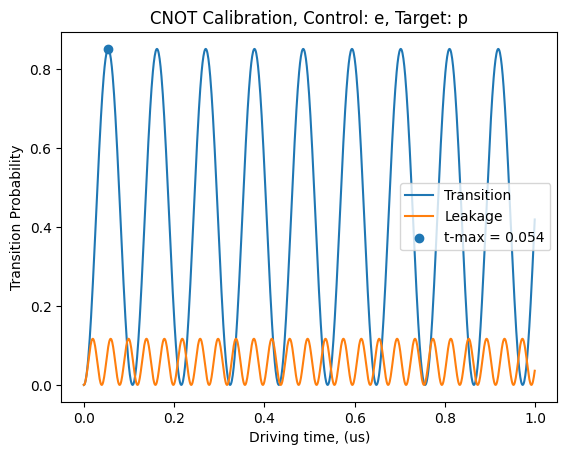

In [216]:
times = np.arange(0,1,.001)
res = qt.mesolve(H_top, rho10, times)
res_leak = qt.mesolve(H_top, rho00, times)

nuc_signal = [qt.expect(rho11, state) for state in res.states]
nuc_signal_other = [qt.expect(rho01, state) for state in res_leak.states]
t_cnot_nuc = times[np.argmax(nuc_signal)]

plt.plot(times,nuc_signal,label="Transition")
plt.plot(times,nuc_signal_other,label="Leakage")
plt.scatter(t_cnot_nuc, np.max(nuc_signal),label=f"t-max = {t_cnot_nuc}")
plt.xlabel("Driving time, (us)")
plt.ylabel("Transition Probability")
plt.title("CNOT Calibration, Control: e, Target: p")
plt.legend()
plt.show()

In [217]:
omega_top

12.08377445979221

In [218]:
np.sqrt( (gamma_p*B - A_para/2)**2 + (-A_perp/2)**2)

12.083774459792265

In [219]:
omega_bot

14.435345170194068

In [220]:
np.sqrt( (gamma_p*B + A_para/2)**2 + (A_perp/2)**2)

14.435345170194159

In [221]:
theta_t = np.arctan( (-A_perp/2) /  (gamma_p*B - A_para/2) )
theta_t/deg

45.23235766087336

In [222]:
theta_b = np.arctan( (A_perp/2) / (gamma_p*B + A_para/2))
theta_b/deg

36.46360729874937

In [223]:
omega_bot*np.cos(theta_b-theta_t) - omega_top

2.182845694757974

In [224]:
omega_bot*np.sin(theta_b-theta_t)

-2.200622536562719